In [ ]:
!pip install -U kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.4 MB/s 


In [ ]:
!pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 500 kB/s 


In [ ]:
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle datasets list 

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          12422        368  1.0              
zusmani/petrolgas-prices-worldwide                              Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1094         71  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           7194        208  0.9705882        
ruchi798/data-science-job-salaries                          

In [ ]:
!kaggle datasets list -s gtzan-dataset-music-genre-classification

ref                                                      title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
andradaolteanu/gtzan-dataset-music-genre-classification  GTZAN Dataset - Music Genre Classification    1GB  2020-03-24 14:05:33          23742        470  0.88235295       
carlthome/gtzan-genre-collection                         GTZAN Genre Collection                        1GB  2019-10-30 07:38:06           3377         52  0.8125           
mantasu/gtzan-stems                                      GTZAN Stems                                  13GB  2021-09-02 18:18:32             34          9  0.9705882        
harish24/music-genre-classification                      Music Genre Classification                  229KB  2020-11-03 08:02:13        

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:40<00:00, 50.7MB/s]
100% 1.21G/1.21G [00:40<00:00, 32.4MB/s]


In [ ]:
!unzip /content/gtzan-dataset-music-genre-classification.zip -d /content/GCL

## Imports

In [ ]:
import os
import gc
import re
import cv2
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import accuracy_score

from typing import Any, Dict, Iterable, Iterator, List, Optional, Tuple, Union

import scipy

import torch_optimizer as optim


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn import metrics, model_selection
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import json
import joblib

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import tensorflow as tf

import librosa
import librosa.display
import IPython.display as ipd

import timm
from contextlib import contextmanager
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.makedirs('MODELS/', exist_ok=True)

In [ ]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

def init_logger(log_file='/content/MODELS/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger



LOGGER = init_logger()


SEED_VAL  = 42
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED):
  random.seed(SEED_VAL)
  np.random.seed(SEED_VAL)
  torch.manual_seed(SEED_VAL)
  torch.cuda.manual_seed_all(SEED_VAL)
  os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
import gc
import time
def free_memory(sleep_time=0.1):
  """ Black magic function to free torch memory and some jupyter whims """
  gc.collect()
  torch.cuda.synchronize()
  gc.collect()
  torch.cuda.empty_cache()
  time.sleep(sleep_time)

In [ ]:
root_dir = "/content/GCL/Data"

In [ ]:
!rm

In [ ]:
!ls {root_dir} | wc -c

71


In [ ]:
!ls {root_dir}

features_30_sec.csv  features_3_sec.csv  genres_original  images_original


In [ ]:
feat30sec_df = pd.read_csv(root_dir + "/features_30_sec.csv")
feat3sec_df  = pd.read_csv(root_dir + "/features_3_sec.csv")

In [ ]:
display(feat30sec_df.head(10))

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,1.297741e+05,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,3.758501e+05,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,1.564676e+05,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,1.843559e+05,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,3.433999e+05,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
5,blues.00005.wav,661794,0.302456,0.087532,0.103494,0.003981,1831.993940,1.030482e+06,1729.653287,201910.508633,3481.517592,3.274440e+06,0.094042,0.0062

In [ ]:
display(feat3sec_df.head(10))

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
5,blues.00000.5.wav,66149,0.376670,0.089702,0.132618,0.003583,1994.915219,211700.619569,2152.767854,74263.873102,4371.985614,1.067105e+06,0.092420,0.001174,-0.00003

In [ ]:
print(f"Data shape : {feat30sec_df.shape}")

Data shape : (1000, 60)


In [ ]:
print(f"Data shape : {feat3sec_df.shape}")

Data shape : (9990, 60)


In [ ]:
!ls {root_dir} | wc -c

71


In [ ]:
!mv {root_dir}/genres_original/blues/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/classical/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/country/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/disco/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/hiphop/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/jazz/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/metal/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/pop/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/reggae/* {root_dir}

In [ ]:
!mv {root_dir}/genres_original/rock/* {root_dir}

In [ ]:
!ls {root_dir} | wc -c

16471


In [ ]:
!rm -r {root_dir}/genres_original

In [ ]:
!rm -r {root_dir}/images_original

In [ ]:
feat30sec_df["duration"] = "30sec"
feat3sec_df["duration"] = "3sec"

In [ ]:
all_data = pd.concat([feat30sec_df, feat3sec_df], axis = 0,ignore_index=True)

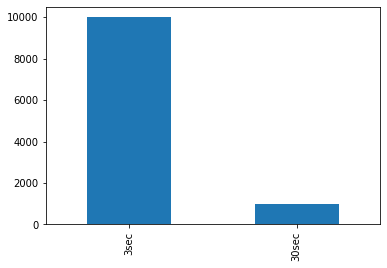

In [ ]:
all_data.duration.value_counts().plot.bar()

In [ ]:
y, s = librosa.load(f'{root_dir}/blues.00023.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', s, '\n')

print('Check Len of Audio:', 661794/22050)

y: [ 0.17184448  0.20730591  0.08227539 ...  0.00271606 -0.02062988
 -0.01370239] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [ ]:
audio, _ = librosa.effects.trim(y)

print('Audio File:', audio, '\n')
print('Audio File shape:', np.shape(audio))

Audio File: [ 0.17184448  0.20730591  0.08227539 ...  0.00271606 -0.02062988
 -0.01370239] 

Audio File shape: (661794,)


# EDA

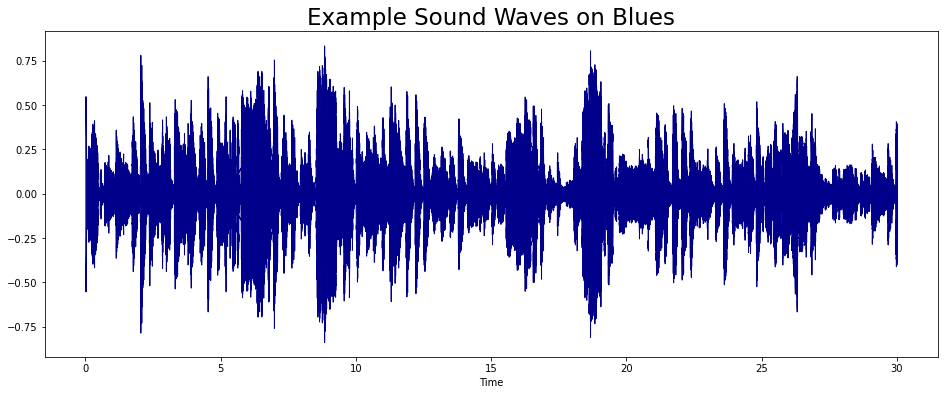

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = s, color = "#00008B");
plt.title("Example Sound Waves on Blues", fontsize = 23);

In [ ]:
#Fourier Transform

fft = 2048
hl = 512

stft = np.abs(librosa.stft(audio, n_fft = fft, hop_length = hl))

print(np.shape(stft))

(1025, 1293)


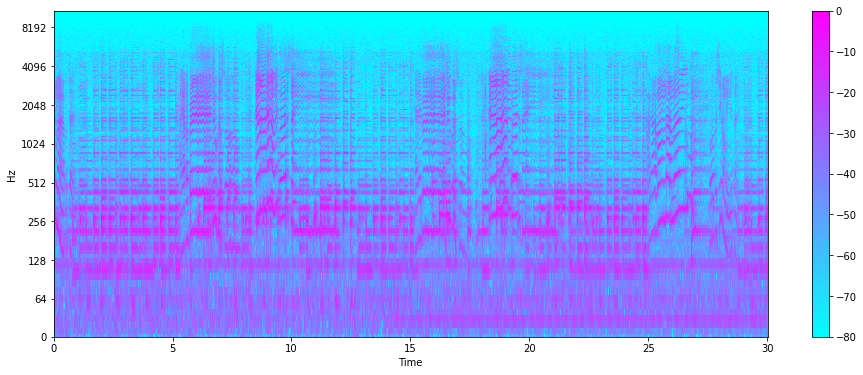

In [ ]:
decibel = librosa.amplitude_to_db(stft, ref = np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(decibel, sr = s, hop_length = hl, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

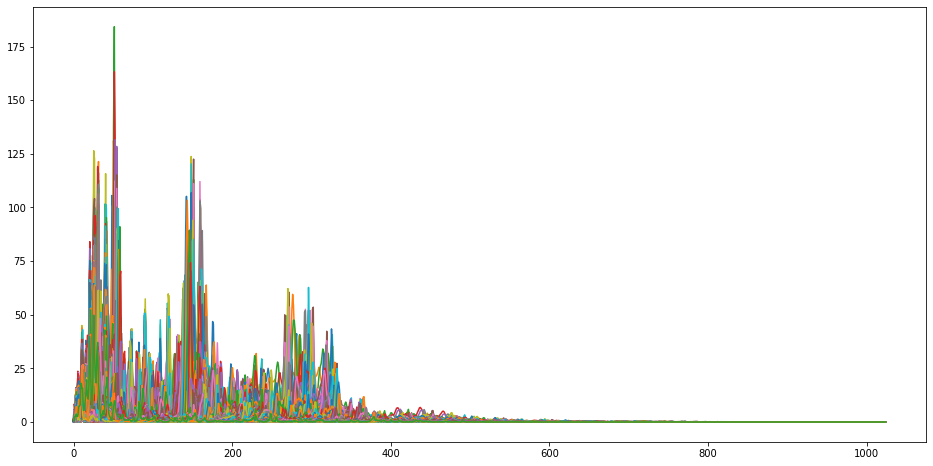

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(stft);

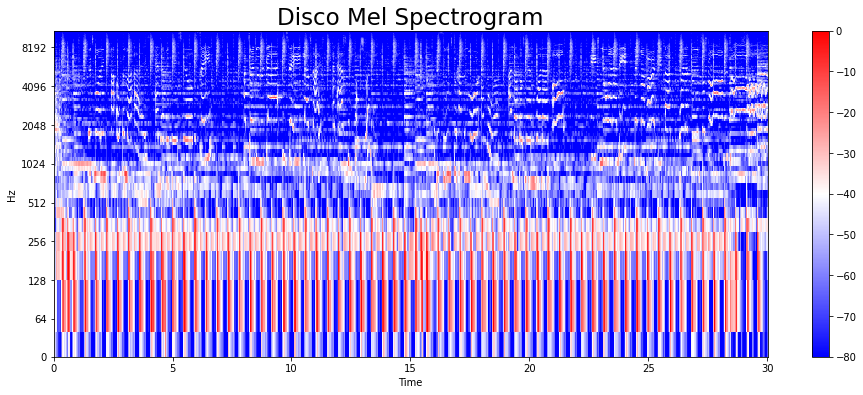

In [ ]:
y, s = librosa.load(f'{root_dir}/disco.00007.wav')
y, z = librosa.effects.trim(y)


mel = librosa.feature.melspectrogram(y, sr=s)
mel_db = librosa.amplitude_to_db(mel, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(mel_db, sr=s, hop_length=hl, x_axis = 'time', y_axis = 'log',
                        cmap = 'bwr');
plt.colorbar();
plt.title("Disco Mel Spectrogram", fontsize = 23);

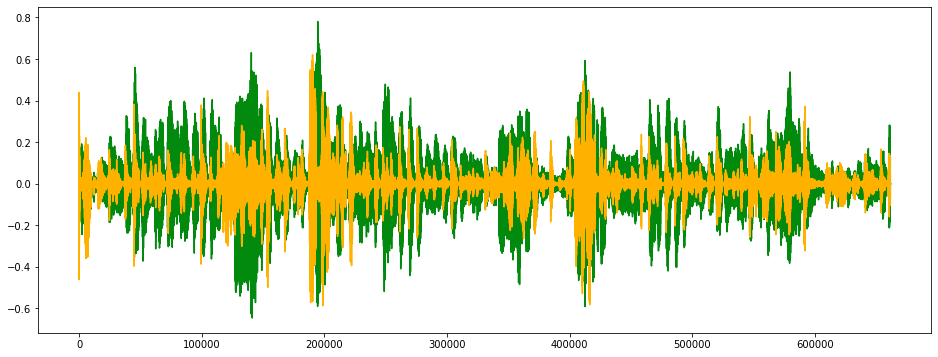

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#028A0F');
plt.plot(y_perc, color = '#FFB100');

In [ ]:
tempo, _ = librosa.beat.beat_track(y, sr = s)
tempo

129.19921875

In [ ]:
sc = librosa.feature.spectral_centroid(audio, sr=s)[0]

print('Centroids:', sc, '\n')
print('Shape of Spectral Centroids:', sc.shape, '\n')

frames = range(len(sc))

t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1293.3245471  1299.14008095 1272.39183755 ...  937.47853521  929.54490235
  929.89471214] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


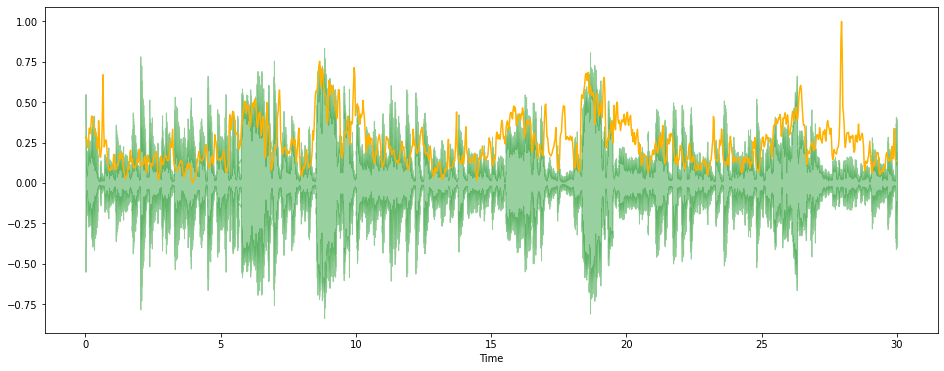

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio, sr=s, alpha=0.4, color = '#028A0F');
plt.plot(t, normalize(sc), color='#FFB100');

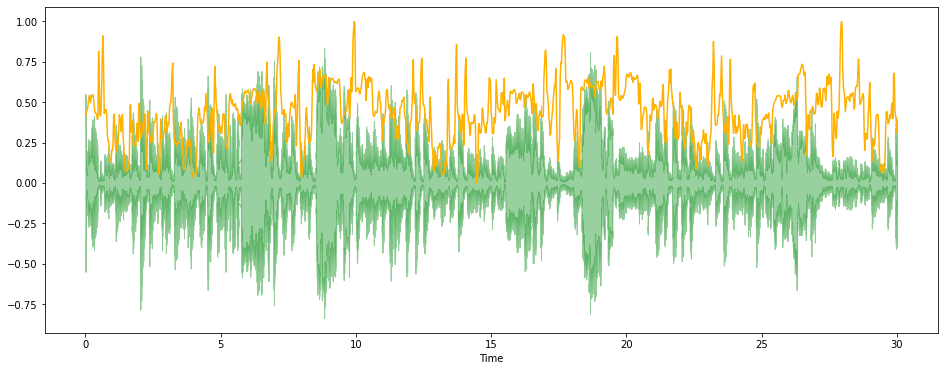

In [ ]:
sr = librosa.feature.spectral_rolloff(audio, sr=s)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio, sr=s, alpha=0.4, color = '#028A0F');
plt.plot(t, normalize(sr), color='#FFB100');

(20, 1293)


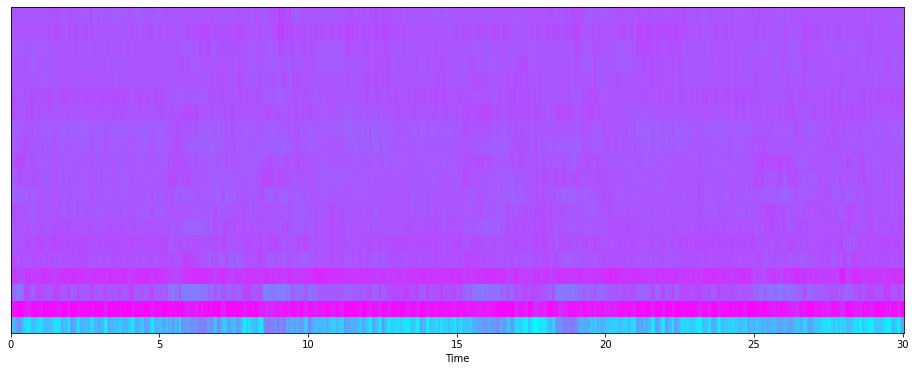

In [ ]:
mfcc = librosa.feature.mfcc(audio, sr=s)
print(mfcc.shape)

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfcc, sr=s, x_axis='time', cmap = 'cool');

Mean: -2.065188e-09 

Var: 1.0


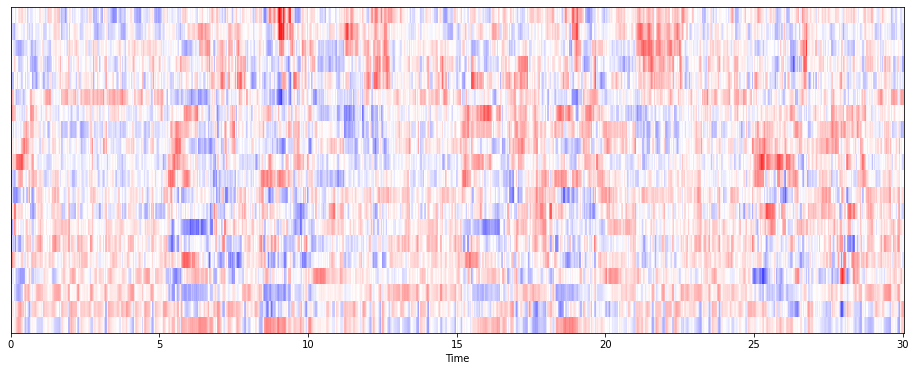

In [ ]:
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
print('Mean:', mfcc.mean(), '\n')
print('Var:', mfcc.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfcc, sr=s, x_axis='time', cmap = 'bwr');

Chromogram shape: (12, 133)


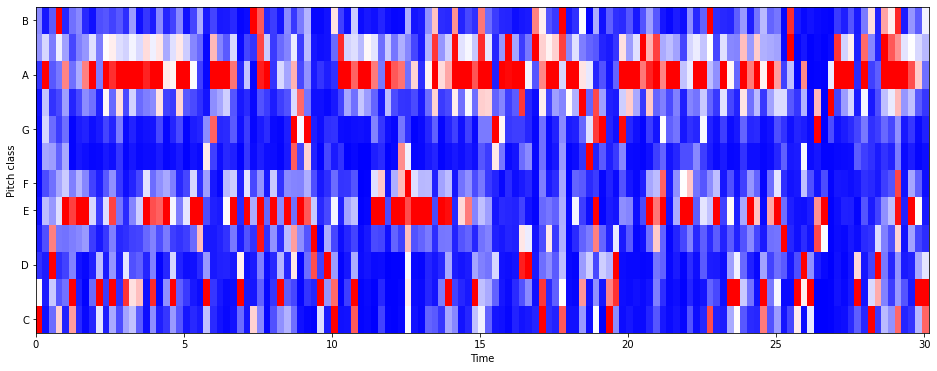

In [ ]:
hl = 5000

#
chromagram = librosa.feature.chroma_stft(audio, sr=s, hop_length=hl)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hl, cmap='bwr');

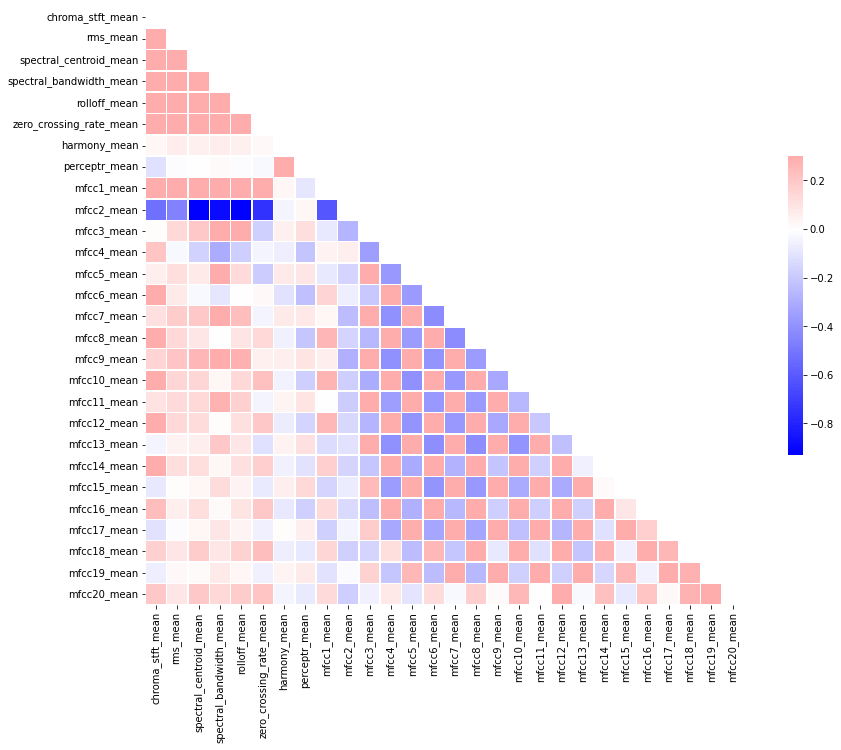

In [ ]:
spike = [col for col in all_data.columns if 'mean' in col]
corr = all_data[spike].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16, 11));

sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

Text(0, 0.5, 'BPM')

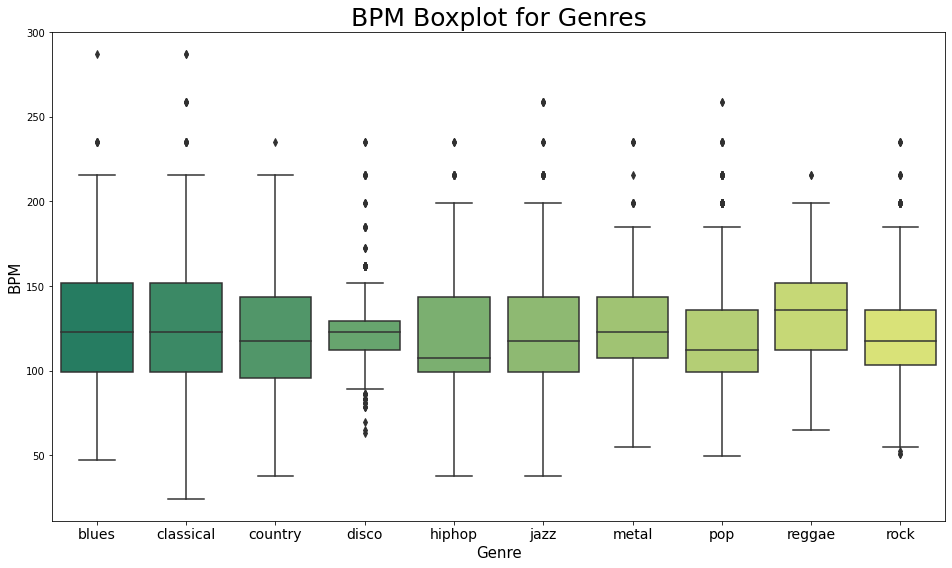

In [ ]:
x = all_data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'summer');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

In [ ]:
remove = [fn for fn in all_data.filename if fn not in os.listdir(root_dir)]

In [ ]:
len(remove)

9990

In [ ]:
df = all_data[~all_data["filename"].isin(remove)].reset_index(drop=True)
df.shape

(1000, 61)

In [ ]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,duration
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,30sec
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,30sec
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,30sec
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,30sec
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,30sec


In [ ]:
skip_files = ["jazz.00054.wav"]

# Config

In [ ]:
class Config:
  sampling_rate = 22050
  duration = 30 # sec
  hop_length = 128*duration # to make time steps 128
  fmin = 20
  fmax = sampling_rate // 2
  n_mels = 92
  n_fft = n_mels * 20
  padmode = 'constant'
  samples = sampling_rate * duration
  ####################### PCEN PARAMS
  gain          = 0.6
  bias          = 0.1 
  power         = 0.2 
  time_constant = 0.4 
  eps           = 1e-9

# Data Utils

In [ ]:
def show_audio(ad):
    sig,sr = ad
    ipd.display(ipd.Audio(data=sig, rate=sr))

In [ ]:
def get_default_conf():
  return Config

In [ ]:
CFG = get_default_conf()

In [ ]:
def audio_to_image_extractor(file_name, cst=5, top_db=80.):

  row_sound, sr = librosa.load(f"{root_dir}/{file_name}",sr=CFG.sampling_rate)
  sound = np.zeros((cst*sr,))

  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, 
                                    sr=CFG.sampling_rate,
                                    n_mels=CFG.n_mels,
                                    hop_length=CFG.hop_length,
                                    n_fft=CFG.n_fft,
                                    fmin=CFG.fmin,
                                    fmax=CFG.fmax)
  spec_pcen = librosa.core.pcen(spec, 
                                  sr= CFG.sampling_rate,
                                  hop_length= CFG.hop_length,
                                  gain= CFG.gain,
                                  bias= CFG.bias,
                                  power= CFG.power,
                                  time_constant = CFG.time_constant,
                                  eps = CFG.eps)
  spec_pcen = spec_pcen.astype(np.float32)

  return spec_pcen

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)

def save_spec_image(spec_img, fname):
  cv2.imwrite(fname, spec_img)

# Generate Spectrograms

In [ ]:
df = df[["filename", "label"]].copy()

In [ ]:
display(df.head(2))

,filename,label
0,blues.00000.wav,blues
1,blues.00001.wav,blues


In [ ]:
#Training specs
for row in tqdm(df.values):
  sound_path = row[0] #this corresponds to 'file_name'
  if sound_path not in skip_files:
    spec_name = sound_path.replace(".wav", ".jpg") #this corresponds to 'spec_name'

    spec = audio_to_image_extractor(sound_path, 30)
    spec = spec_to_image(spec)
    save_spec_image(spec, spec_name)
  else:
    continue
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
!mkdir Imgs # make directory to move spectrograms

In [ ]:
!mv *.jpg Imgs

# Zip Generated Spectrograms

In [ ]:
!zip -r PCEN_92_128.zip Imgs -q

In [ ]:
!mv PCEN_92_128.zip /content/drive/MyDrive/code_league_project/

# Model Utils

In [ ]:
data_dir = "/content/drive/MyDrive/code_league_project/"

In [ ]:
!ls {data_dir}

models	PCEN_92_128.zip


In [ ]:
!ls Imgs | wc -c

16385


# Create Folds

In [ ]:
df = df[~df.filename.isin(['jazz.00054.wav'])].reset_index(drop=True)
display(df.head(2))

,filename,label
0,blues.00000.wav,blues
1,blues.00001.wav,blues


In [ ]:
train , test = sklearn.model_selection.train_test_split(df , test_size = 0.1, stratify=df.label, random_state = SEED_VAL)

print(f"train: {train.shape}, test: {test.shape}")

train: (899, 2), test: (100, 2)


In [ ]:
n_folds = 10 # can change folds

In [ ]:
train['fold'] = 0

train = train.sample(frac=1).reset_index(drop=True)

fold = StratifiedKFold(n_splits = n_folds, random_state=SEED_VAL,shuffle=True)
for i, (tr, vr) in enumerate(fold.split(train.index, train['label'])):
  train.loc[vr, 'fold'] = int(i)

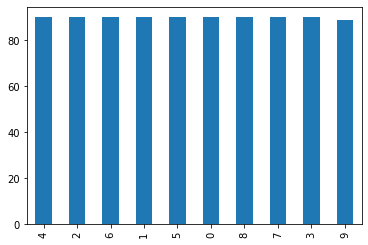

In [ ]:
train.fold.value_counts().plot.bar()

In [ ]:
cols_labels = pd.get_dummies(train['label'] ,prefix='genre')
train = pd.concat([train,cols_labels],axis=1 ) 
train.head()

,filename,label,fold,genre_blues,genre_classical,genre_country,genre_disco,genre_hiphop,genre_jazz,genre_metal,genre_pop,genre_reggae,genre_rock
0,pop.00069.wav,pop,4,0,0,0,0,0,0,0,1,0,0
1,disco.00004.wav,disco,2,0,0,0,1,0,0,0,0,0,0
2,jazz.00056.wav,jazz,6,0,0,0,0,0,1,0,0,0,0
3,jazz.00072.wav,jazz,6,0,0,0,0,0,1,0,0,0,0
4,country.00025.wav,country,4,0,0,1,0,0,0,0,0,0,0


In [ ]:
train["spec_name"] = train["filename"].apply(lambda x : f"/content/Imgs/{x.replace('.wav', '.jpg')}")

In [ ]:
test["spec_name"] = test["filename"].apply(lambda x : f"/content/Imgs/{x.replace('.wav', '.jpg')}")

In [ ]:
train.iloc[0, 3:-1]

genre_blues        0
genre_classical    0
genre_country      0
genre_disco        0
genre_hiphop       0
genre_jazz         0
genre_metal        0
genre_pop          1
genre_reggae       0
genre_rock         0
Name: 0, dtype: object

In [ ]:
test.head()

,filename,label,spec_name
392,disco.00092.wav,disco,/content/Imgs/disco.00092.jpg
416,hiphop.00016.wav,hiphop,/content/Imgs/hiphop.00016.jpg
106,classical.00006.wav,classical,/content/Imgs/classical.00006.jpg
21,blues.00021.wav,blues,/content/Imgs/blues.00021.jpg
962,rock.00063.wav,rock,/content/Imgs/rock.00063.jpg


## Create Dataset

In [ ]:
preds_cols = train.columns.tolist()[3:-1]

genre_labs = np.linspace(0, len(preds_cols)-1, len(preds_cols), dtype = np.int8)
mapper = dict(zip(genre_labs, preds_cols))

joblib.dump(mapper, f"{data_dir}/label_mapper.joblib")
gc.collect()

24485

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
  
  def __init__(self, df, task='train', size=(300, 230), **kwargs):
    super(AudioDataset, self).__init__()
    self.df = df
    self.task = task
    self.size = size
    self.c = len(preds_cols)
    self.classes = preds_cols

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fn = self.df.loc[idx, 'spec_name']

    spec = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    spec = cv2.resize(spec, self.size)

    output = {
        'spec': torch.tensor(spec, dtype=torch.float).unsqueeze(0),
    }

    if self.task=='train':
      output.update({'label': torch.tensor(np.argmax(self.df.iloc[idx,4:-1].values)) })

    return output

# Save transformed data

In [ ]:
train.to_csv(f"{data_dir}/train.csv", index=False)
test.to_csv(f"{data_dir}/test.csv", index=False)

In [ ]:
train.iloc[0, 3:-1]

genre_blues        0
genre_classical    0
genre_country      0
genre_disco        0
genre_hiphop       0
genre_jazz         0
genre_metal        0
genre_pop          1
genre_reggae       0
genre_rock         0
Name: 0, dtype: object

# Model Config

In [ ]:
# ====================================================
# CFG
# ====================================================

class CFG:
    print_freq=100
    num_workers = 4
    model_name =  'densenet201'
    family = "Densenet201"

    pretrained = True

    size = (500, 230)
    optimizer_name = "adamw" #["shampoo", "adam", "adamw", "madgrad"]
    epochs = 50
    factor = 0.2
    drop_rate = 0.4
    patience = 5
    eps = 1e-6
    lr = 1e-4
    min_lr = 1e-6
    batch_size = 8
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 42
    eta_min = 1e-5


    target_size = 10
    target_col = 'label'
    n_fold = 20
    trn_fold = np.linspace(0, (n_fold-1), n_fold, dtype=np.int8)

In [ ]:
print(CFG.trn_fold)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## Model

In [ ]:
####### ATTENTION MODULES

'''
Borrowed from https://www.kaggle.com/jy2tong/efficientnet-b2-soft-attention
'''

class PAM_Module(nn.Module):
    ''' Position attention module'''
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in  = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma      = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        '''
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        '''
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key   = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy     = torch.bmm(proj_query, proj_key)
        attention  = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out


class CAM_Module(nn.Module):
    ''' Channel attention module'''
    def __init__(self, in_dim):
        super(CAM_Module, self).__init__()
        self.chanel_in = in_dim
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self,x):
        '''
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        '''
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key   = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy     = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention  = torch.softmax(energy_new, dim=-1)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)
        out = self.gamma*out + x
        
        return out


class CBAM(nn.Module):
    def __init__(self, in_channels):
        # def __init__(self):
        super(CBAM, self).__init__()
        inter_channels = in_channels // 4
        self.conv1_c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU())
        
        self.conv1_s = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU())

        self.channel_gate = CAM_Module(inter_channels)
        self.spatial_gate = PAM_Module(inter_channels)

        self.conv2_c = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU())
        self.conv2_a = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU())

    def forward(self, x):
        feat1    = self.conv1_c(x)
        chnl_att = self.channel_gate(feat1)
        chnl_att = self.conv2_c(chnl_att)

        feat2    = self.conv1_s(x)
        spat_att = self.spatial_gate(feat2)
        spat_att = self.conv2_a(spat_att)

        x_out = chnl_att + spat_att

        return x_out

In [ ]:
class model_with_attention(nn.Module):
    
    def __init__(self, CFG):
        super().__init__()
        self.backbone            = timm.create_model(model_name = CFG.model_name, pretrained = True)
        self.backbone._dropout   = nn.Dropout(0.1)
        n_features               = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(n_features, CFG.target_size)
        self.local_fe            = CBAM(n_features)
        self.dropout             = nn.Dropout(0.1)
        self.classifier          = nn.Sequential(nn.Linear(n_features + n_features, n_features),
                                                nn.BatchNorm1d(n_features),
                                                nn.Dropout(0.1),
                                                nn.ReLU(),
                                                nn.Linear(n_features, CFG.target_size))

    def forward(self, image):
        enc_feas    = self.backbone.forward_features(image)
        global_feas = self.backbone.global_pool(enc_feas)
        global_feas = global_feas.flatten(start_dim = 1)
        global_feas = self.dropout(global_feas)
        local_feas  = self.local_fe(enc_feas)
        local_feas  = torch.sum(local_feas, dim = [2, 3])
        local_feas  = self.dropout(local_feas)
        all_feas    = torch.cat([global_feas, local_feas], dim = 1)
        outputs     = self.classifier(all_feas)
        return outputs
    
# model = model_with_attention(CFG)

In [ ]:
class AudioModel(torch.nn.Module):
  def __init__(self, arch_name='resnet34',Family="resnet", pretrained=True, fc_size=512, out_size=10, **kwargs):
        super(AudioModel, self).__init__()

        self.arch = timm.create_model(arch_name, pretrained=pretrained)

        if Family =='Densenet201' :
            head = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            head.weight = torch.nn.Parameter(self.arch.features.conv0.weight.sum(dim=1, keepdim=True))

            self.arch.features.conv0 = head
            fc_size = self.arch.classifier.in_features
            self.arch.classifier = nn.Sequential(nn.Linear(fc_size, out_size))
        elif Family =='Densenet161' :
            head = torch.nn.Conv2d(1,  96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
            head.weight = torch.nn.Parameter(self.arch.features.conv0.weight.sum(dim=1, keepdim=True))

            self.arch.features.conv0 = head
            fc_size = self.arch.classifier.in_features
            self.arch.classifier = nn.Sequential(nn.Linear(fc_size, out_size))

        elif Family =='resnet' :
          head = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
          head.weight = torch.nn.Parameter(self.arch.conv1.weight.sum(dim=1, keepdim=True))

          self.arch.conv1 = head
          fc_size = self.arch.fc.in_features
          self.arch.fc = nn.Sequential(nn.Linear(fc_size, out_size))

  def forward(self, x):
    x = self.arch(x)
    return x

## Early Stopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter}/{self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(val_loss, model)

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        checkpoint = {"config": Config, "model_state_dict": model.state_dict()}

        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Train Loop

In [ ]:
# ====================================================
# helper functions
# ====================================================

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    start = end = time.time()
    global_step = 0
    for step, d in enumerate(train_loader):
        data_time.update(time.time() - end)
        images = d['spec'].to(device)
        labels = d['label'].to(device)

        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels )
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, d in enumerate(valid_loader):
        data_time.update(time.time() - end)
        images = d['spec'].to(device)
        labels = d['label'].to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Scorer

In [ ]:
def get_score(y_true, y_pred):
    return log_loss(y_true, y_pred)

# Runner

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import log_loss

In [ ]:
# ====================================================
# train loop
# ====================================================

def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")


    trn_idx = folds[folds['fold'] != fold].index
    train_folds = folds.loc[trn_idx].reset_index(drop=True)

    val_idx = folds[folds['fold'] == fold].index
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = AudioDataset(df = train_folds, task = "train",  size = CFG.size)
    valid_dataset = AudioDataset(df = valid_folds, task =  "train", size = CFG.size)

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, 
                              shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, 
                              shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


    model = AudioModel(arch_name = CFG.model_name,pretrained=CFG.pretrained, Family =CFG.family)
    model.to(device)

    if CFG.optimizer_name == "shampoo":
      optimizer = optim.Shampoo(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer_name == "madgrad":
      optimizer = optim.MADGRAD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer_name == "adam":
      optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer_name == "adamw":
      optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    else:
      RuntimeError("optimizer name is invalid!")

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)

    es = EarlyStopping(
        patience=CFG.patience, verbose=True, path=f'/content/MODELS/{CFG.model_name}_fold{fold}_best.pth'
    ) 


  
    criterion = nn.CrossEntropyLoss()

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        es(avg_val_loss, model)

        scheduler.step(avg_val_loss)
        score = get_score(valid_labels, preds)
        elapsed = time.time() - start_time
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Logloss: {score}')
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 'preds': preds}, f'/content/MODELS/{CFG.model_name}_fold{fold}_best.pth')

        elif es.early_stop:
            print("early stopping...")
            break
    
    check_point = torch.load(f'/content/MODELS/{CFG.model_name}_fold{fold}_best.pth')
    valid_folds.loc[:, preds_cols] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

# Train

In [ ]:
# ====================================================
# main function
# ====================================================

def main():

    def get_result(result_df):
        preds = result_df[preds_cols].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    oof_df = pd.DataFrame()
    for fold in range(CFG.n_fold):
        free_memory(sleep_time=0.1)
        if fold in CFG.trn_fold:
            _oof_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
            
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_csv(f'/content/MODELS/{CFG.model_name}_{CFG.optimizer_name}_oof_df.csv', index=False)

In [ ]:
free_memory()

# Train Model

In [ ]:
if __name__ == '__main__':
  main()

Epoch: [9][100/106] Data 0.000 (0.003) Elapsed 1m 7s (remain 0m 3s) Loss: 0.1705(0.0584) Grad: 8.3509  
Epoch: [9][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0914(0.0578) Grad: 4.5913  
EVAL: [0/6] Data 0.203 (0.203) Elapsed 0m 0s (remain 0m 1s) Loss: 1.7468(1.7468) 


Epoch 9 - avg_train_loss: 0.0578  avg_val_loss: 0.7318  time: 72s
Epoch 9 - Logloss: 0.7318130122264848


EVAL: [5/6] Data 0.000 (0.034) Elapsed 0m 1s (remain 0m 0s) Loss: 0.0256(0.7318) 
EarlyStopping counter: 1/5
Epoch: [10][0/106] Data 0.233 (0.233) Elapsed 0m 0s (remain 1m 34s) Loss: 0.0346(0.0346) Grad: 1.7518  
Epoch: [10][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 0.2096(0.0818) Grad: 12.5084  
Epoch: [10][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0859(0.0817) Grad: 5.6212  
EVAL: [0/6] Data 0.225 (0.225) Elapsed 0m 0s (remain 0m 1s) Loss: 2.0248(2.0248) 


Epoch 10 - avg_train_loss: 0.0817  avg_val_loss: 0.9218  time: 72s
Epoch 10 - Logloss: 0.921774370136619


EVAL: [5/6] Data 0.000 (0.038) Elapsed 0m 1s (remain 0m 0s) Loss: 0.0807(0.9218) 
EarlyStopping counter: 2/5
Epoch: [11][0/106] Data 0.231 (0.231) Elapsed 0m 0s (remain 1m 33s) Loss: 0.0458(0.0458) Grad: 2.3315  
Epoch: [11][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 0.0386(0.1138) Grad: 1.6044  
Epoch: [11][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0691(0.1133) Grad: 3.8162  
EVAL: [0/6] Data 0.224 (0.224) Elapsed 0m 0s (remain 0m 1s) Loss: 1.1190(1.1190) 


Epoch 11 - avg_train_loss: 0.1133  avg_val_loss: 0.5686  time: 72s
Epoch 11 - Logloss: 0.568643767985567


EVAL: [5/6] Data 0.000 (0.038) Elapsed 0m 1s (remain 0m 0s) Loss: 0.1007(0.5686) 
EarlyStopping counter: 3/5
Epoch: [12][0/106] Data 0.244 (0.244) Elapsed 0m 0s (remain 1m 36s) Loss: 0.0775(0.0775) Grad: 3.9878  
Epoch: [12][100/106] Data 0.000 (0.003) Elapsed 1m 7s (remain 0m 3s) Loss: 0.0191(0.0599) Grad: 0.7442  
Epoch: [12][105/106] Data 0.000 (0.003) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0130(0.0586) Grad: 0.8464  
EVAL: [0/6] Data 0.204 (0.204) Elapsed 0m 0s (remain 0m 1s) Loss: 1.8452(1.8452) 


Epoch 12 - avg_train_loss: 0.0586  avg_val_loss: 0.8946  time: 72s
Epoch 12 - Logloss: 0.8945714184910887


EVAL: [5/6] Data 0.000 (0.034) Elapsed 0m 1s (remain 0m 0s) Loss: 0.0064(0.8946) 
EarlyStopping counter: 4/5
Epoch: [13][0/106] Data 0.215 (0.215) Elapsed 0m 0s (remain 1m 32s) Loss: 0.0234(0.0234) Grad: 0.8147  
Epoch: [13][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 0.0112(0.0402) Grad: 0.8305  
Epoch: [13][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0250(0.0437) Grad: 1.3346  
EVAL: [0/6] Data 0.235 (0.235) Elapsed 0m 0s (remain 0m 1s) Loss: 2.0934(2.0934) 


Epoch 13 - avg_train_loss: 0.0437  avg_val_loss: 0.6674  time: 72s
Epoch 13 - Logloss: 0.6674441527921267


EVAL: [5/6] Data 0.000 (0.039) Elapsed 0m 1s (remain 0m 0s) Loss: 0.0046(0.6674) 
EarlyStopping counter: 5/5
early stopping...


========== fold: 18 result ==========
Score: 0.50327
========== fold: 19 training ==========


Epoch: [1][0/106] Data 0.216 (0.216) Elapsed 0m 1s (remain 2m 18s) Loss: 2.5177(2.5177) Grad: 10.4828  
Epoch: [1][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 1.2474(1.5013) Grad: 9.7350  
Epoch: [1][105/106] Data 0.000 (0.002) Elapsed 1m 11s (remain 0m 0s) Loss: 1.0106(1.4834) Grad: 8.9512  
EVAL: [0/6] Data 0.207 (0.207) Elapsed 0m 0s (remain 0m 1s) Loss: 0.7462(0.7462) 
EVAL: [5/6] Data 0.000 (0.035) Elapsed 0m 1s (remain 0m 0s) Loss: 0.9936(0.8301) 
Validation loss decreased (inf --> 0.830115).  Saving model ...


Epoch 1 - avg_train_loss: 1.4834  avg_val_loss: 0.8301  time: 73s
Epoch 1 - Logloss: 0.8301148580556567
Epoch 1 - Save Best Score: 0.8301 Model


Epoch: [2][0/106] Data 0.227 (0.227) Elapsed 0m 1s (remain 2m 5s) Loss: 1.1138(1.1138) Grad: 9.0723  
Epoch: [2][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 0.8236(0.8921) Grad: 9.3447  
Epoch: [2][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 1.1803(0.8963) Grad: 11.2584  
EVAL: [0/6] Data 0.233 (0.233) Elapsed 0m 0s (remain 0m 1s) Loss: 0.5293(0.5293) 
EVAL: [5/6] Data 0.000 (0.039) Elapsed 0m 1s (remain 0m 0s) Loss: 1.3831(0.7853) 
Validation loss decreased (0.830115 --> 0.785312).  Saving model ...


Epoch 2 - avg_train_loss: 0.8963  avg_val_loss: 0.7853  time: 72s
Epoch 2 - Logloss: 0.7853118344950913
Epoch 2 - Save Best Score: 0.7853 Model


Epoch: [3][0/106] Data 0.246 (0.246) Elapsed 0m 0s (remain 1m 35s) Loss: 0.3919(0.3919) Grad: 5.5097  
Epoch: [3][100/106] Data 0.000 (0.003) Elapsed 1m 6s (remain 0m 3s) Loss: 0.4692(0.5944) Grad: 7.9028  
Epoch: [3][105/106] Data 0.000 (0.003) Elapsed 1m 10s (remain 0m 0s) Loss: 1.0012(0.5987) Grad: 14.2190  
EVAL: [0/6] Data 0.229 (0.229) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2326(0.2326) 
EVAL: [5/6] Data 0.000 (0.039) Elapsed 0m 1s (remain 0m 0s) Loss: 1.0626(0.5349) 
Validation loss decreased (0.785312 --> 0.534948).  Saving model ...


Epoch 3 - avg_train_loss: 0.5987  avg_val_loss: 0.5349  time: 72s
Epoch 3 - Logloss: 0.534947908303531
Epoch 3 - Save Best Score: 0.5349 Model


Epoch: [4][0/106] Data 0.215 (0.215) Elapsed 0m 0s (remain 1m 32s) Loss: 0.6225(0.6225) Grad: 9.0982  
Epoch: [4][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 0.3606(0.3655) Grad: 11.4594  
Epoch: [4][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.5105(0.3696) Grad: 8.5484  
EVAL: [0/6] Data 0.219 (0.219) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2011(0.2011) 


Epoch 4 - avg_train_loss: 0.3696  avg_val_loss: 0.7483  time: 72s
Epoch 4 - Logloss: 0.7482551715749485


EVAL: [5/6] Data 0.000 (0.037) Elapsed 0m 1s (remain 0m 0s) Loss: 1.1732(0.7483) 
EarlyStopping counter: 1/5
Epoch: [5][0/106] Data 0.245 (0.245) Elapsed 0m 0s (remain 1m 35s) Loss: 0.2941(0.2941) Grad: 15.4906  
Epoch: [5][100/106] Data 0.000 (0.003) Elapsed 1m 6s (remain 0m 3s) Loss: 0.1840(0.2347) Grad: 6.8150  
Epoch: [5][105/106] Data 0.000 (0.003) Elapsed 1m 10s (remain 0m 0s) Loss: 0.1007(0.2328) Grad: 4.4161  
EVAL: [0/6] Data 0.228 (0.228) Elapsed 0m 0s (remain 0m 1s) Loss: 0.1640(0.1640) 


Epoch 5 - avg_train_loss: 0.2328  avg_val_loss: 0.5422  time: 72s
Epoch 5 - Logloss: 0.5421827416919934


EVAL: [5/6] Data 0.000 (0.038) Elapsed 0m 1s (remain 0m 0s) Loss: 1.2139(0.5422) 
EarlyStopping counter: 2/5
Epoch: [6][0/106] Data 0.244 (0.244) Elapsed 0m 0s (remain 1m 35s) Loss: 0.4157(0.4157) Grad: 11.2091  
Epoch: [6][100/106] Data 0.000 (0.003) Elapsed 1m 7s (remain 0m 3s) Loss: 0.3287(0.1431) Grad: 14.9277  
Epoch: [6][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.2178(0.1402) Grad: 6.9802  
EVAL: [0/6] Data 0.222 (0.222) Elapsed 0m 0s (remain 0m 1s) Loss: 0.1998(0.1998) 
EVAL: [5/6] Data 0.000 (0.037) Elapsed 0m 1s (remain 0m 0s) Loss: 1.0614(0.4401) 
Validation loss decreased (0.534948 --> 0.440067).  Saving model ...


Epoch 6 - avg_train_loss: 0.1402  avg_val_loss: 0.4401  time: 72s
Epoch 6 - Logloss: 0.4400674495846033
Epoch 6 - Save Best Score: 0.4401 Model


Epoch: [7][0/106] Data 0.203 (0.203) Elapsed 0m 0s (remain 1m 31s) Loss: 0.0338(0.0338) Grad: 1.3654  
Epoch: [7][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 0.1274(0.1278) Grad: 6.4500  
Epoch: [7][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0974(0.1300) Grad: 4.5780  
EVAL: [0/6] Data 0.225 (0.225) Elapsed 0m 0s (remain 0m 1s) Loss: 0.3360(0.3360) 


Epoch 7 - avg_train_loss: 0.1300  avg_val_loss: 0.6916  time: 72s
Epoch 7 - Logloss: 0.6915571849283217


EVAL: [5/6] Data 0.000 (0.038) Elapsed 0m 1s (remain 0m 0s) Loss: 1.5838(0.6916) 
EarlyStopping counter: 1/5
Epoch: [8][0/106] Data 0.236 (0.236) Elapsed 0m 0s (remain 1m 34s) Loss: 0.1125(0.1125) Grad: 3.8215  
Epoch: [8][100/106] Data 0.000 (0.003) Elapsed 1m 7s (remain 0m 3s) Loss: 0.1461(0.1187) Grad: 4.9541  
Epoch: [8][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0900(0.1156) Grad: 3.6249  
EVAL: [0/6] Data 0.223 (0.223) Elapsed 0m 0s (remain 0m 1s) Loss: 0.4395(0.4395) 


Epoch 8 - avg_train_loss: 0.1156  avg_val_loss: 0.6855  time: 72s
Epoch 8 - Logloss: 0.6854783307472562


EVAL: [5/6] Data 0.000 (0.037) Elapsed 0m 1s (remain 0m 0s) Loss: 1.2622(0.6855) 
EarlyStopping counter: 2/5
Epoch: [9][0/106] Data 0.236 (0.236) Elapsed 0m 0s (remain 1m 34s) Loss: 0.0631(0.0631) Grad: 2.6083  
Epoch: [9][100/106] Data 0.000 (0.003) Elapsed 1m 7s (remain 0m 3s) Loss: 0.0519(0.1063) Grad: 2.3464  
Epoch: [9][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.1067(0.1052) Grad: 6.0827  
EVAL: [0/6] Data 0.221 (0.221) Elapsed 0m 0s (remain 0m 1s) Loss: 0.3488(0.3488) 


Epoch 9 - avg_train_loss: 0.1052  avg_val_loss: 0.9517  time: 72s
Epoch 9 - Logloss: 0.9516692576600524


EVAL: [5/6] Data 0.000 (0.037) Elapsed 0m 1s (remain 0m 0s) Loss: 2.4407(0.9517) 
EarlyStopping counter: 3/5
Epoch: [10][0/106] Data 0.216 (0.216) Elapsed 0m 0s (remain 1m 32s) Loss: 0.1245(0.1245) Grad: 8.0193  
Epoch: [10][100/106] Data 0.000 (0.002) Elapsed 1m 7s (remain 0m 3s) Loss: 0.0574(0.0989) Grad: 4.4074  
Epoch: [10][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.3851(0.1051) Grad: 16.2909  
EVAL: [0/6] Data 0.235 (0.235) Elapsed 0m 0s (remain 0m 1s) Loss: 0.0389(0.0389) 


Epoch 10 - avg_train_loss: 0.1051  avg_val_loss: 0.6106  time: 72s
Epoch 10 - Logloss: 0.6106097422029548


EVAL: [5/6] Data 0.000 (0.040) Elapsed 0m 1s (remain 0m 0s) Loss: 1.6203(0.6106) 
EarlyStopping counter: 4/5
Epoch: [11][0/106] Data 0.241 (0.241) Elapsed 0m 0s (remain 1m 35s) Loss: 0.0335(0.0335) Grad: 1.9431  
Epoch: [11][100/106] Data 0.000 (0.003) Elapsed 1m 7s (remain 0m 3s) Loss: 0.0078(0.0653) Grad: 0.3239  
Epoch: [11][105/106] Data 0.000 (0.002) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0247(0.0632) Grad: 1.8018  
EVAL: [0/6] Data 0.221 (0.221) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2043(0.2043) 


Epoch 11 - avg_train_loss: 0.0632  avg_val_loss: 0.5028  time: 72s
Epoch 11 - Logloss: 0.5027595283847238


EVAL: [5/6] Data 0.000 (0.037) Elapsed 0m 1s (remain 0m 0s) Loss: 0.7097(0.5028) 
EarlyStopping counter: 5/5
early stopping...


========== fold: 19 result ==========
Score: 0.44007
========== CV ==========
Score: 0.56004


# Inference

In [ ]:
pretrained_models = {
    f"{CFG.model_name}" : [f'/content/content/MODELS/{CFG.model_name}_fold{fold}_best.pth' for fold in CFG.trn_fold]
    }

In [ ]:
test.head()

,filename,label,spec_name
392,disco.00092.wav,disco,/content/Imgs/disco.00092.jpg
416,hiphop.00016.wav,hiphop,/content/Imgs/hiphop.00016.jpg
106,classical.00006.wav,classical,/content/Imgs/classical.00006.jpg
21,blues.00021.wav,blues,/content/Imgs/blues.00021.jpg
962,rock.00063.wav,rock,/content/Imgs/rock.00063.jpg


In [ ]:
test = test[~test.filename.isin(skip_files)].reset_index(drop=True)
test.shape

(100, 3)

In [ ]:
test_ds = AudioDataset(df = test, task='test', size= CFG.size)
testloader = DataLoader(test_ds, batch_size=CFG.batch_size, 
                        shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [ ]:
from scipy.stats.mstats import gmean

In [ ]:
def inference(model, states, test_loader, device):

  model.to(device)

  probabilities = []
  for i, data in enumerate(test_loader):
    images = data["spec"].to(device)
    avg_preds = []
    for state in states:
      model.load_state_dict(state['model'])
      model.eval()
      with torch.no_grad():
        y_preds = model(images)
      avg_preds.append(y_preds.softmax(1).to('cpu').numpy())

    avg_preds = gmean(avg_preds, axis=0)

    probabilities.append(avg_preds)
  return np.concatenate(probabilities)

# Load Pretrained Models

In [ ]:
!unzip /content/drive/MyDrive/code_league_project/models/pretrained_models.zip 

Archive:  /content/drive/MyDrive/code_league_project/models/pretrained_models.zip
  inflating: content/MODELS/densenet201_fold0_best.pth  
  inflating: content/MODELS/densenet201_fold10_best.pth  
  inflating: content/MODELS/densenet201_fold11_best.pth  
  inflating: content/MODELS/densenet201_fold12_best.pth  
  inflating: content/MODELS/densenet201_fold13_best.pth  
  inflating: content/MODELS/densenet201_fold14_best.pth  
  inflating: content/MODELS/densenet201_fold15_best.pth  
  inflating: content/MODELS/densenet201_fold16_best.pth  
  inflating: content/MODELS/densenet201_fold17_best.pth  
  inflating: content/MODELS/densenet201_fold18_best.pth  
  inflating: content/MODELS/densenet201_fold19_best.pth  
  inflating: content/MODELS/densenet201_fold1_best.pth  
  inflating: content/MODELS/densenet201_fold2_best.pth  
  inflating: content/MODELS/densenet201_fold3_best.pth  
  inflating: content/MODELS/densenet201_fold4_best.pth  
  inflating: content/MODELS/densenet201_fold5_best.pt

# Inference

In [ ]:
states = [torch.load(f) for f in pretrained_models[f"{CFG.model_name}"]]

In [ ]:
model = AudioModel(arch_name = CFG.model_name,pretrained=CFG.pretrained, Family =CFG.family)

In [ ]:
predictions = inference(model, states, testloader, device)

In [ ]:
predictions_df = pd.DataFrame()
predictions_df["Image_id"] = test["filename"].values
predictions_df["ground_truth"] = test["label"].values
predictions_df['image_path_id'] = data_dir + predictions_df['Image_id'].astype(str)

In [ ]:
predictions_df

,Image_id,ground_truth,image_path_id
0,disco.00092.wav,disco,/content/drive/MyDrive/code_league_project/dis...
1,hiphop.00016.wav,hiphop,/content/drive/MyDrive/code_league_project/hip...
2,classical.00006.wav,classical,/content/drive/MyDrive/code_league_project/cla...
3,blues.00021.wav,blues,/content/drive/MyDrive/code_league_project/blu...
4,rock.00063.wav,rock,/content/drive/MyDrive/code_league_project/roc...
5,disco.00007.wav,disco,/content/drive/MyDrive/code_league_project/dis...
6,disco.00021.wav,disco,/content/drive/MyDrive/code_league_project/dis...
7,pop.00025.wav,pop,/content/drive/MyDrive/code_league_project/pop...
8,country.00018.wav,country,/content/drive/MyDrive/code_league_project/cou...
9,hiphop.00098.wav,hiphop,/content/drive/MyDrive/code_league_project/hip...


In [ ]:
predictions_df.loc[:, preds_cols] = [np.squeeze(p) for p in predictions]
predictions_df["label"] = np.argmax(predictions_df[preds_cols].values, axis=1)
predictions_df = predictions_df.drop(["image_path_id"], axis=1)


torch.cuda.empty_cache()
try:
    del(model)
    del(states)
except:
    pass
gc.collect()

19140

In [ ]:
genre_labs = np.linspace(0, len(preds_cols)-1, len(preds_cols), dtype = np.int8)
mapper = dict(zip(genre_labs, preds_cols))
mapper

{0: 'genre_blues',
 1: 'genre_classical',
 2: 'genre_country',
 3: 'genre_disco',
 4: 'genre_hiphop',
 5: 'genre_jazz',
 6: 'genre_metal',
 7: 'genre_pop',
 8: 'genre_reggae',
 9: 'genre_rock'}

In [ ]:
predictions_df["genre"] = predictions_df["label"].map(mapper)

In [ ]:
predictions_df.head(10)

,Image_id,ground_truth,genre_blues,genre_classical,genre_country,genre_disco,genre_hiphop,genre_jazz,genre_metal,genre_pop,genre_reggae,genre_rock,label,genre
0,disco.00092.wav,disco,0.000268,0.000006,0.000168,0.979526,0.000163,0.000072,0.000093,0.000132,0.000020,0.000787,3,genre_disco
1,hiphop.00016.wav,hiphop,0.000177,0.000018,0.000083,0.000316,0.973283,0.000164,0.000263,0.000765,0.000729,0.000159,4,genre_hiphop
2,classical.00006.wav,classical,0.000066,0.996350,0.000166,0.000104,0.000013,0.000095,0.000074,0.000037,0.000035,0.000975,1,genre_classical
3,blues.00021.wav,blues,0.989572,0.000181,0.000603,0.000146,0.000092,0.000711,0.000103,0.000112,0.000628,0.000187,0,genre_blues
4,rock.00063.wav,rock,0.002672,0.001458,0.006070,0.000441,0.000424,0.001242,0.000831,0.001895,0.004092,0.655740,9,genre_rock
5,disco.00007.wav,disco,0.000029,0.000011,0.000428,0.956988,0.000221,0.000029,0.000053,0.000647,0.000130,0.001507,3,genre_disco
6,disco.00021.wav,disco,0.000129,0.000063,0.000167,0.943194,0.000154,0.000094,0.000098,0.001493,0.000252,0.001337,3,genre_disco
7,pop.00025.wav,pop,0.000158,0.000059,0.000377,0.000733,0.000336,0.000099,0.000193,0.971131,0.000494,0.001067,7,genre_pop
8,country.00018.wav,country,0.000369,0.000189,0.947549,0.000165,0.000017,0.000182,0.000026,0.000097,0.000388,0.000746,2,genre_country
9,hiphop.00098.wav,hiphop,0.000191,0.000011,0.000127,0.000468,0.976986,0.000066,0.000277,0.000247,0.000419,0.000159,4,genre_hiphop


In [ ]:
predictions_df["genre"] = predictions_df["genre"].apply(lambda x: x.replace("genre_", ""))

In [ ]:
predictions_df.head()

,Image_id,ground_truth,genre_blues,genre_classical,genre_country,genre_disco,genre_hiphop,genre_jazz,genre_metal,genre_pop,genre_reggae,genre_rock,label,genre
0,disco.00092.wav,disco,0.000268,0.000006,0.000168,0.979526,0.000163,0.000072,0.000093,0.000132,0.000020,0.000787,3,disco
1,hiphop.00016.wav,hiphop,0.000177,0.000018,0.000083,0.000316,0.973283,0.000164,0.000263,0.000765,0.000729,0.000159,4,hiphop
2,classical.00006.wav,classical,0.000066,0.996350,0.000166,0.000104,0.000013,0.000095,0.000074,0.000037,0.000035,0.000975,1,classical
3,blues.00021.wav,blues,0.989572,0.000181,0.000603,0.000146,0.000092,0.000711,0.000103,0.000112,0.000628,0.000187,0,blues
4,rock.00063.wav,rock,0.002672,0.001458,0.006070,0.000441,0.000424,0.001242,0.000831,0.001895,0.004092,0.655740,9,rock


In [ ]:
# accuracy

print(f"Model Accuracy : {(sum(predictions_df['ground_truth'] == predictions_df['genre'])/predictions_df.shape[0])*100} % ")

In [ ]:
# !zip -r pretrained_models.zip /content/MODELS/*.pth -q

In [ ]:
# !mv pretrained_models.zip /content/drive/MyDrive/code_league_project/models/